### Build local cache file from Argo data sources
*Execute commands to pull data from the Internet into a local HDF cache file so that we can better interact with the data*

On a development system (where we have not executed a `pip install oxyfloat`) we need to add the oxyfloat directory to the Python search path. Do this before starting the notebook server with (replace `~/dev/oxyfloatgit/` with the directory where you cloned the oxyfloat project):

```bash
export PYTHONPATH=~/dev/oxyfloatgit/
cd ~/dev/oxyfloatgit/notebooks
ipython notebook
```

Alternatively, you can set the path interactively, e.g.:

In [1]:
import sys
sys.path.insert(0, 'C:\Users\saca\Documents\GitHub\oxyfloat')

Import the OxyFloat class and instatiate an OxyFloat object (`of`) with verbosity set to 2 so that we get INFO messages.

In [2]:
from oxyfloat import OxyFloat
of = OxyFloat(verbosity=2)

You can now explore what methods the of object has by typing "`of.`" in a cell and pressing the tab key. One of the methods is `get_oxy_floats()`; to see what it does select it and press shift-tab with the cursor in the parentheses of "`of.get_oxy_floats()`". Let's get a list of all the floats that have been out for at least 340 days and print the length of that list.

In [3]:
%%time
floats340 = of.get_oxy_floats_from_status(age_gte=340)
print('{} floats at least 340 days old'.format(len(floats340)))

INFO:root:Reading data from http://argo.jcommops.org/FTPRoot/Argo/Status/argo_all.txt
INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): argo.jcommops.org
INFO:root:Saving DataFrame to name "status" in file /home/mccann/dev/oxyfloatgit/oxyfloat/oxyfloat_cache.hdf


563 floats at least 340 days old
CPU times: user 304 ms, sys: 245 ms, total: 549 ms
Wall time: 45.5 s


/home/mccann/dev/oxyfloatgit/oxyfloat/OxyFloat.py:177: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['WMO', 'TELECOM', 'TTYPE', 'MY_ID', 'SERIAL_NO', 'DATE0', 'NOTIF_DATE', 'SHIP', 'CRUISE', 'DATE_', 'MODEL', 'FULL_NAME', 'EMAIL', 'PROGRAM', 'COUNTRY']]

  self._put_df(self._status_to_df(), self._STATUS)


If this the first time you've executed the cell it will take minute or so to read the Argo status information from the Internet (the PerformanceWarning can be ignored - for this small table it doesn't matter much). 

Once the status information is read it is cached locally and further calls to `get_oxy_floats_from_status()` will execute much faster. To demonstrate, let's count all the oxygen labeled floats that have been out for at least 2 years. 

In [4]:
%%time
floats730 = of.get_oxy_floats_from_status(age_gte=730)
print('{} floats at least 730 days old'.format(len(floats730)))

400 floats at least 730 days old
CPU times: user 29 ms, sys: 2 ms, total: 31 ms
Wall time: 62.5 ms


Now let's find the Data Assembly Center URL for each of the floats in our list. (The returned dictionary of URLs is also locally cached.)

In [5]:
%%time
dac_urls = of.get_dac_urls(floats340)
print(len(dac_urls))

INFO:root:Reading data from ftp://ftp.ifremer.fr/ifremer/argo/ar_index_global_meta.txt
INFO:root:Saving DataFrame to name "global_meta" in file /home/mccann/dev/oxyfloatgit/oxyfloat/oxyfloat_cache.hdf


562
CPU times: user 819 ms, sys: 16 ms, total: 835 ms
Wall time: 6.06 s


Now, whenever we need to get profile data our lookups for status and Data Assembly Centers will be serviced from the local cache. Let's get a Pandas DataFrame (`df`) of 20 profiles from the float with WMO number 1900650.

In [6]:
%%time
wmo_list = ['1900650']
of.set_verbosity(0)
df = of.get_float_dataframe(wmo_list, max_profiles=20)

CPU times: user 2.31 s, sys: 224 ms, total: 2.54 s
Wall time: 1min 59s


Profile data is also cached locally. To demonstrate, perform the same command as in the previous cell and note the time difference.

In [7]:
%%time
df = of.get_float_dataframe(wmo_list, max_profiles=20)

CPU times: user 818 ms, sys: 2 ms, total: 820 ms
Wall time: 2.2 s


Examine the first 5 records of the float data.

In [8]:
df.head()

TEMP_ADJUSTED  PSAL_ADJUSTED  \
wmo     time                depth                                 
1900650 2010-03-11T17:39:40 4.3        29.790001      34.827457   
                            5.9        29.789000      34.827457   
                            9.1        29.790001      34.827457   
                            13.9       29.787001      34.826454   
                            19.5       29.681999      34.847443   

                                   DOXY_ADJUSTED  PRES_ADJUSTED  LATITUDE  \
wmo     time                depth                                           
1900650 2010-03-11T17:39:40 4.3       206.490005       4.300000     6.031   
                            5.9       206.380005       5.900000     6.031   
                            9.1       206.300003       9.100000     6.031   
                            13.9      206.850006      13.900001     6.031   
                            19.5      206.860001      19.500000     6.031   

                                   LONGITUDE                       JULD  
wmo     time                depth                                        
1900650 2010-03-11T17:39:40 4.3      -14.026 2010-03-12 01:39:40.003200  
                            5.9      -14.026 2010-03-12 01:39:40.003200  
                            9.1      -14.026 2010-03-12 01:39:40.003200  
                            13.9     -14.026 2010-03-12 01:39:40.003200  
                            19.5     -14.026 2010-03-12 01:39:40.003200

There's a lot that can be done with the profile data in this DataFrame structure. We can construct a `time_range` string and query for all the data values from less than 10 decibars:

In [9]:
time_range = '{} to {}'.format(df['JULD'].min().strftime('%Y-%m-%d'), 
                               df['JULD'].max().strftime('%Y-%m-%d'))
df.query('depth < 10')

TEMP_ADJUSTED  PSAL_ADJUSTED  \
wmo     time                depth                                 
1900650 2010-03-11T17:39:40 4.3        29.790001      34.827457   
                            5.9        29.789000      34.827457   
                            9.1        29.790001      34.827457   
        2010-02-19T17:52:38 4.5        29.492001      35.149502   
                            6.3        29.457001      35.153496   
                            9.2        29.434000      35.152500   
        2010-02-09T17:57:26 4.5        29.674000      34.764793   
                            6.2        29.673000      34.765797   
                            9.4        29.617001      34.786785   
        2010-01-30T17:02:30 4.4        29.191999      34.660965   
                            6.4        29.132000      34.664963   
                            9.5        29.115000      34.712933   
        2010-01-20T18:05:11 4.6        29.114000      35.037857   
                            6.4        29.025999      35.034855   
                            9.2        28.968000      35.023865   
        2010-01-10T17:07:43 4.5        29.048000      34.390392   
                            6.2        29.048000      34.390392   
                            9.1        29.048000      34.395390   
        2009-12-31T17:10:18 4.4        28.839001      34.216640   
                            6.0        28.862000      34.228630   
                            8.8        28.836000      34.553371   
        2009-12-21T17:12:05 4.8        28.965000      33.655815   
                            6.7        29.115999      33.865715   
                            9.5        29.010000      34.214714   
        2009-12-11T15:35:43 4.3        28.674000      34.808380   
                            6.1        28.673000      34.810379   
                            9.0        28.671000      34.811378   
        2009-12-01T15:41:39 4.5        28.465000      34.510677   
                            6.3        28.465000      34.510677   
                            9.2        28.485001      34.549644   
...                                          ...            ...   
        2009-11-11T15:15:41 4.6        28.788000      34.482895   
                            6.4        28.797001      34.609802   
                            9.2        28.775000      34.615799   
        2009-11-01T18:46:59 4.0        28.396999      34.665897   
                            6.2        28.402000      34.667896   
                            9.2        28.412001      34.669895   
        2009-10-22T18:23:59 4.7        28.409000      34.756943   
                            6.2        28.372000      34.756943   
                            9.0        28.368000      34.758938   
        2009-10-12T20:00:00 4.4        28.069000      34.562168   
                            6.3        28.084999      34.563168   
                            9.3        28.105000      34.574162   
        2009-10-02T16:46:59 4.6        27.764000      34.812119   
                            6.2        27.766001      34.814114   
                            8.9        27.768000      34.814114   
        2009-09-22T18:30:00 4.2        27.465000      34.911167   
                            6.0        27.466000      34.911167   
                            9.0        27.465000      34.910168   
        2009-09-12T16:12:59 4.1        27.099001      35.067207   
                            6.1        27.117001      35.077198   
                            8.8        27.129999      35.087196   
        2009-09-02T18:39:59 4.4        27.277000      34.633526   
                            6.0        27.278000      34.633526   
                            9.0        27.275999      34.633526   
        2009-08-23T18:36:59 4.3        27.177000      34.635628   
                            6.1        27.177000      34.635628   
                            9.4        27.173000      34.634624   
        2009-08

In one command we can take the mean of all the values from the upper 10 decibars:

In [10]:
df.query('depth < 10').groupby(level=['wmo', 'time']).mean()

TEMP_ADJUSTED  PSAL_ADJUSTED  DOXY_ADJUSTED  \
wmo     time                                                               
1900650 2009-08-13T18:38:00      26.906000      35.160473     194.656667   
        2009-08-23T18:36:59      27.175667      34.635293     196.166667   
        2009-09-02T18:39:59      27.277000      34.633526     200.486664   
        2009-09-12T16:12:59      27.115334      35.077201     202.010000   
        2009-09-22T18:30:00      27.465333      34.910834     191.626668   
        2009-10-02T16:46:59      27.766000      34.813449     182.533335   
        2009-10-12T20:00:00      28.086333      34.566499     160.286667   
        2009-10-22T18:23:59      28.383000      34.757608      50.989999   
        2009-11-01T18:46:59      28.403667      34.667896     145.029999   
        2009-11-11T15:15:41      28.786667      34.569499     123.626668   
        2009-11-21T17:18:26      29.077667      34.545078     118.360001   
        2009-12-01T15:41:39      28.471667      34.523666     142.169998   
        2009-12-11T15:35:43      28.672667      34.810046     163.026667   
        2009-12-21T17:12:05      29.030333      33.912081     142.753332   
        2009-12-31T17:10:18      28.845667      34.332881     180.740000   
        2010-01-10T17:07:43      29.048000      34.392058     199.673335   
        2010-01-20T18:05:11      29.036000      35.032192     198.990000   
        2010-01-30T17:02:30      29.146333      34.679620     194.313334   
        2010-02-09T17:57:26      29.654667      34.772458     189.586670   
        2010-02-19T17:52:38      29.461000      35.151833     204.206665   
        2010-03-11T17:39:40      29.789667      34.827457     206.390004   

                             PRES_ADJUSTED  LATITUDE  LONGITUDE  
wmo     time                                                     
1900650 2009-08-13T18:38:00       6.266666     7.582    -18.703  
        2009-08-23T18:36:59       6.600000     7.558    -17.952  
        2009-09-02T18:39:59       6.466667     7.552    -17.122  
        2009-09-12T16:12:59       6.333333     7.049    -17.252  
        2009-09-22T18:30:00       6.400000     6.054    -17.463  
        2009-10-02T16:46:59       6.566666     5.626    -17.357  
        2009-10-12T20:00:00       6.666667     5.618    -16.724  
        2009-10-22T18:23:59       6.633333     5.742    -16.597  
        2009-11-01T18:46:59       6.466667     5.963    -16.458  
        2009-11-11T15:15:41       6.733333     6.140    -15.862  
        2009-11-21T17:18:26       6.766667     6.241    -15.311  
        2009-12-01T15:41:39       6.666667     6.082    -15.373  
        2009-12-11T15:35:43       6.466667     5.600    -15.374  
        2009-12-21T17:12:05       7.000000     5.685    -15.207  
        2009-12-31T17:10:18       6.400000     5.184    -15.162  
        2010-01-10T17:07:43       6.600000     5.117    -15.128  
        2010-01-20T18:05:11       6.733333     5.719    -15.077  
        2010-01-30T17:02:30       6.766667     5.725    -15.038  
        2010-02-09T17:57:26       6.700000     5.492    -14.929  
        2010-02-19T17:52:38       6.666667     5.551    -14.866  
        2010-03-11T17:39:40       6.433334     6.031    -14.026

We can plot the profiles:

Populating the interactive namespace from numpy and matplotlib


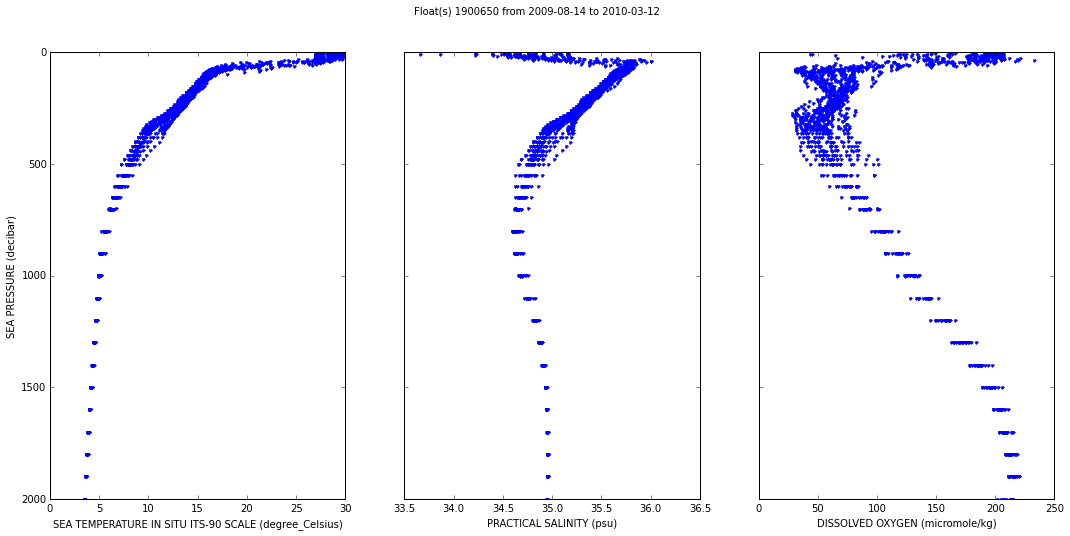

In [11]:
%pylab inline
import pylab as plt
# Parameter long_name and units copied from attributes in NetCDF files
parms = {'TEMP_ADJUSTED': 'SEA TEMPERATURE IN SITU ITS-90 SCALE (degree_Celsius)', 
         'PSAL_ADJUSTED': 'PRACTICAL SALINITY (psu)',
         'DOXY_ADJUSTED': 'DISSOLVED OXYGEN (micromole/kg)'}

plt.rcParams['figure.figsize'] = (18.0, 8.0)
fig, ax = plt.subplots(1, len(parms), sharey=True)
ax[0].invert_yaxis()
ax[0].set_ylabel('SEA PRESSURE (decibar)')

for i, (p, label) in enumerate(parms.iteritems()):
    ax[i].set_xlabel(label)
    ax[i].plot(df[p], df['PRES_ADJUSTED'], '.')
    
plt.suptitle('Float(s) ' + ' '.join(wmo_list) + ' from ' + time_range)

We can plot the location of these profiles on a map:

/home/mccann/VirtualEnvs/oxyfloat/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


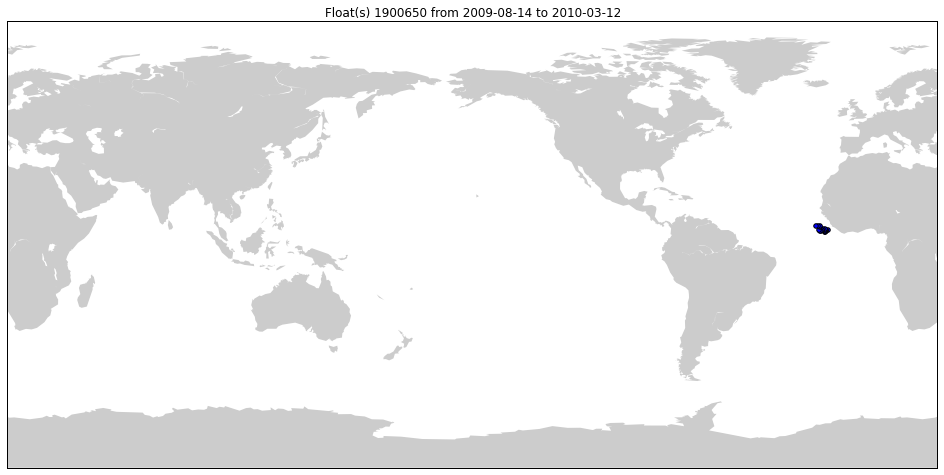

In [12]:
from mpl_toolkits.basemap import Basemap

m = Basemap(llcrnrlon=15, llcrnrlat=-90, urcrnrlon=390, urcrnrlat=90, projection='cyl')
m.fillcontinents(color='0.8')

m.scatter(df['LONGITUDE'].unique(), df['LATITUDE'].unique(), latlon=True)
plt.title('Float(s) ' + ' '.join(wmo_list) + ' from ' + time_range)